In [1]:
import renom as rm
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import sys
sys.path.append('../src')
from network import network
from func import Mahalanobis
from sklearn.metrics import confusion_matrix, classification_report
from time import time
from myutils import get_figratio

In [2]:
#データロードと設定
data = np.load('../data/mnist.npy', allow_pickle=True)
y_train = data[0][0]
x_train = data[0][1].astype('float32')/255.
y_test = data[1][0]
x_test = data[1][1].astype('float32')/255.
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

In [25]:
random.seed(10) #擬似乱数シード固定
latent_dim = 12 #潜在変数空間の次元数
epoch = 10 #学習エポック数
batch_size = 256 #バッチサイズ
opt = rm.Adam() #勾配最適化関数
# 以下はネットワーク定義
ae = network((batch_size, 28*28), epoch=epoch, latent_dim=latent_dim)

In [26]:
# 学習 （学習カーブ等はnotebook/result/内に保存、潜在変数次元が3以上は潜在変数空間をスナップショットとらない設定）
ae.train(opt, x_train, x_test, y_train, y_test)

#    1/   10 KL:2.994 ReconE:23.990 ETA:0.0sec 0.02,0.08,0.10            
*    2/   10 KL:4.910 ReconE:15.912 ETA:0.0sec 0.01,0.07,0.08            
-----------------------------------
#    3/   10 KL:5.499 ReconE:14.579 ETA:0.0sec 0.01,0.08,0.10            
*    4/   10 KL:5.451 ReconE:13.627 ETA:0.0sec 0.02,0.08,0.10            
-----------------------------------
#    5/   10 KL:5.669 ReconE:13.191 ETA:0.0sec 0.02,0.08,0.10            
*    6/   10 KL:5.454 ReconE:12.621 ETA:0.0sec 0.02,0.08,0.10            
-----------------------------------
#    7/   10 KL:5.589 ReconE:12.380 ETA:0.0sec 0.01,0.08,0.10            
*    8/   10 KL:5.296 ReconE:11.925 ETA:0.0sec 0.02,0.08,0.10            
-----------------------------------
#    9/   10 KL:5.367 ReconE:11.765 ETA:0.0sec 0.02,0.08,0.10            
*   10/   10 KL:5.067 ReconE:11.376 ETA:0.0sec 0.02,0.08,0.10            
-----------------------------------


In [27]:
#学習データの推論
_, z_train, xz_train = ae.mini_batch(opt, x_train, inference=True)

In [46]:
#推論した学習データの潜在変数ベクトルとラベルから共分散行列を計算
f = Mahalanobis(z_train, y_train)
#ラベルの外れ値をどの程度許容するか
f.set_th(0.9998)

Computing Dist
 1.1920928955078125e-05sec


In [47]:
#テストデータの推論
_, z_test, xz_test = ae.mini_batch(opt, x_test, inference=True)

(0, 5)

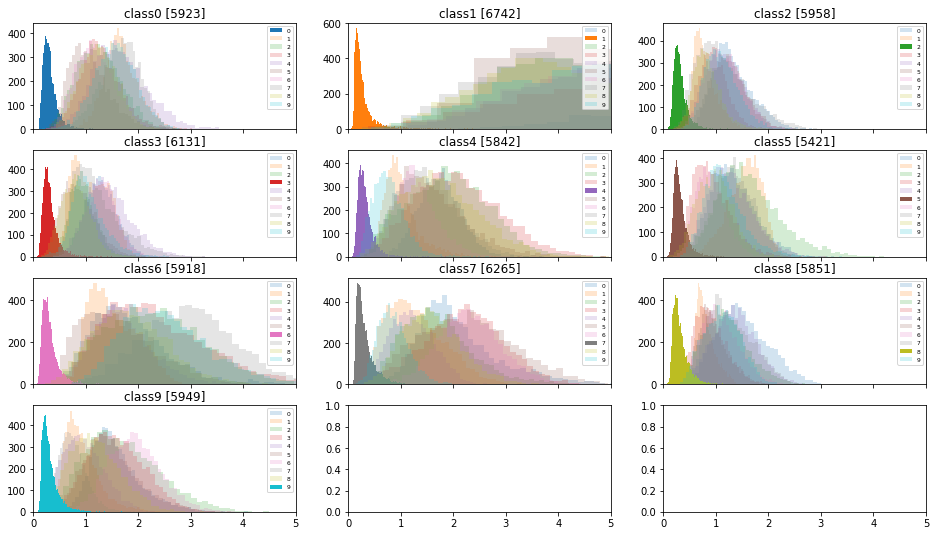

In [87]:
x, y, z = x_train, y_train, z_train
labels =np.unique(y)
nr, nc = get_figratio(len(labels))
m = []
for i in labels:
    idx = np.where(y==i)[0]
    m.append(f.predict(z[idx]))

fig, ax = plt.subplots(nr, nc, figsize=(16, 9), sharex=True)
for _ax, i in zip(ax.flat, labels):
    _ax.set_title(f'class{i} [{len(m[i])}]')
    for j in labels:
        a = 1 if i==j else 0.2
        h, e = np.histogram(m[j].T[i], bins='auto')
        fc = plt.get_cmap('tab10')(j/9)
        _ax.bar(e[:-1], h, e[1:]-e[:-1], align='edge', fc=fc, alpha=a, label=f'{j}')
    _ax.legend(fontsize=6, loc=1)
_ax.set_xlim(0, 5)

(0, 5)

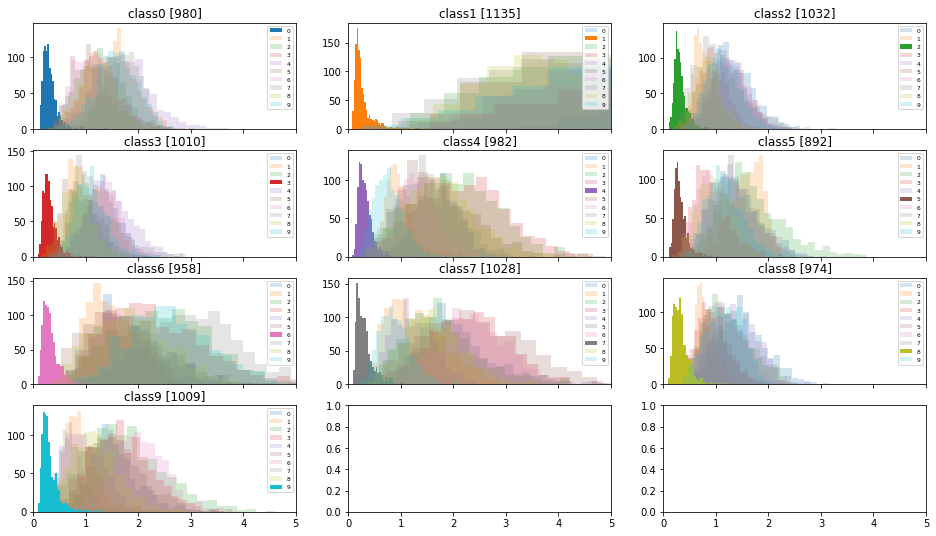

In [63]:
x, y, z = x_test, y_test, z_test
labels =np.unique(y)
nr, nc = get_figratio(len(labels))
m = []
for i in labels:
    idx = np.where(y==i)[0]
    m.append(f.predict(z[idx]))

fig, ax = plt.subplots(nr, nc, figsize=(16, 9), sharex=True)
for _ax, i in zip(ax.flat, labels):
    _ax.set_title(f'class{i} [{len(m[i])}]')
    for j in labels:
        a = 1 if i==j else 0.2
        h, e = np.histogram(m[j].T[i], bins='auto')
        fc = plt.get_cmap('tab10')(j/9)
        _ax.bar(e[:-1], h, e[1:]-e[:-1], align='edge', fc=fc, alpha=a, label=f'{j}')
    _ax.legend(fontsize=6, loc=1)
_ax.set_xlim(0, 5)

In [34]:
from scipy.stats import chi

In [81]:
mean, var, skew, kurt = chi.stats(x, 3, moments='mvsk')

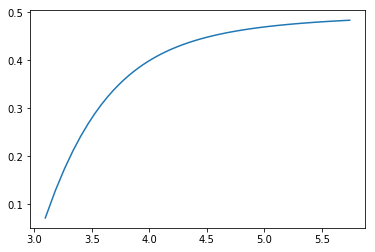

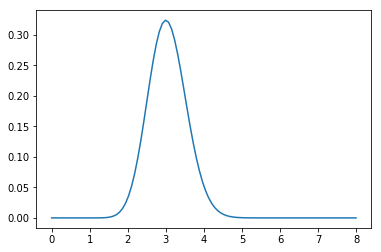

In [74]:
x = np.linspace(0, 8, 100)
g = chi(latent_dim, 0)
plt.plot(x, np.square(chi.pdf(x, 10)))

In [38]:
f.pdf(x)

(array([0.        , 0.08080808, 0.16161616, 0.24242424, 0.32323232,
        0.4040404 , 0.48484848, 0.56565657, 0.64646465, 0.72727273,
        0.80808081, 0.88888889, 0.96969697, 1.05050505, 1.13131313,
        1.21212121, 1.29292929, 1.37373737, 1.45454545, 1.53535354,
        1.61616162, 1.6969697 , 1.77777778, 1.85858586, 1.93939394,
        2.02020202, 2.1010101 , 2.18181818, 2.26262626, 2.34343434,
        2.42424242, 2.50505051, 2.58585859, 2.66666667, 2.74747475,
        2.82828283, 2.90909091, 2.98989899, 3.07070707, 3.15151515,
        3.23232323, 3.31313131, 3.39393939, 3.47474747, 3.55555556,
        3.63636364, 3.71717172, 3.7979798 , 3.87878788, 3.95959596,
        4.04040404, 4.12121212, 4.2020202 , 4.28282828, 4.36363636,
        4.44444444, 4.52525253, 4.60606061, 4.68686869, 4.76767677,
        4.84848485, 4.92929293, 5.01010101, 5.09090909, 5.17171717,
        5.25252525, 5.33333333, 5.41414141, 5.49494949, 5.57575758,
        5.65656566, 5.73737374, 5.81818182, 5.89

In [33]:
#テストデータの潜在変数ベクトルからクラス分類
process_t = time()
pred = np.argmin(f.predict(z_test), 1)
print('{:.2f}sec'.format(time()-process_t))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

6.45sec
[[ 960    0    1    1    0    9    1    1    7    0]
 [   0 1058   14   15    2    0    2    2   40    2]
 [  16    0  978    3    6    2    4    5   16    2]
 [   6    0    9  942    0   15    0    7   26    5]
 [   4    0    8    0  934    3    2    3    2   26]
 [  12    0    4   21    5  835    3    2    9    1]
 [  15    1    6    0    5   26  900    0    5    0]
 [   2    3   54    2    5    3    0  909    4   46]
 [   6    0   10   27    7   25    2    3  887    7]
 [   6    2    5   13   31    5    0   11   11  925]]
             precision    recall  f1-score   support

          0       0.93      0.98      0.96       980
          1       0.99      0.93      0.96      1135
          2       0.90      0.95      0.92      1032
          3       0.92      0.93      0.93      1010
          4       0.94      0.95      0.94       982
          5       0.90      0.94      0.92       892
          6       0.98      0.94      0.96       958
          7       0.96      0.88    

In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(z_train, y_train.reshape(-1))

In [13]:
process_t = time()
pred = knn.predict(z_test)
print('{:.2f}sec'.format(time()-process_t))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

2.17sec
[[ 967    1    0    0    0    1    9    1    1    0]
 [   0 1126    3    2    1    0    2    0    1    0]
 [   6    1  995    5    2    0    2    5   16    0]
 [   0    0   14  947    1   12    1    5   27    3]
 [   3    0    3    0  921    1    8    3    3   40]
 [   6    1    2   17    3  835   10    1   11    6]
 [   3    3    1    0    4    5  938    0    4    0]
 [   1   13   13    2    5    0    1  968    2   23]
 [   5    0    7   25    2   11    1    2  920    1]
 [   4    5    3   10   31    2    1   11   11  931]]
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.98      0.99      0.99      1135
          2       0.96      0.96      0.96      1032
          3       0.94      0.94      0.94      1010
          4       0.95      0.94      0.94       982
          5       0.96      0.94      0.95       892
          6       0.96      0.98      0.97       958
          7       0.97      0.94    